# Task 1: Data Preparation and Exploration

Q1. Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

Q2. Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

Q3. Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('exchange_rate.csv')
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [2]:
# Parse the 'date' column as datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

# Display the dataframe after parsing the date column
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


Now, 'df' contains the dataset with the 'date' column parsed as datetime objects.

In [3]:
# Examine the structure of the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns)
print("\nData Types:\n", df.dtypes)

Dataset Shape: (7588, 2)

Columns: Index(['date', 'Ex_rate'], dtype='object')

Data Types:
 date       datetime64[ns]
Ex_rate           float64
dtype: object


In [4]:
# Check for null values
df.isna().sum()

date       0
Ex_rate    0
dtype: int64

We can conlcude that there are no null values in this dataset.

In [5]:
# Describe the exchange rate column
df.Ex_rate.describe()

count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: Ex_rate, dtype: float64

In [6]:
# Set 'date' column as index
df.set_index('date', inplace=True)
df.index=pd.to_datetime(df.index)
df.dropna(inplace=True)
df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [7]:
df['Ex_rate'].unique()

array([0.7855  , 0.7818  , 0.7867  , ..., 0.719735, 0.723197, 0.720825])

<Axes: xlabel='date'>

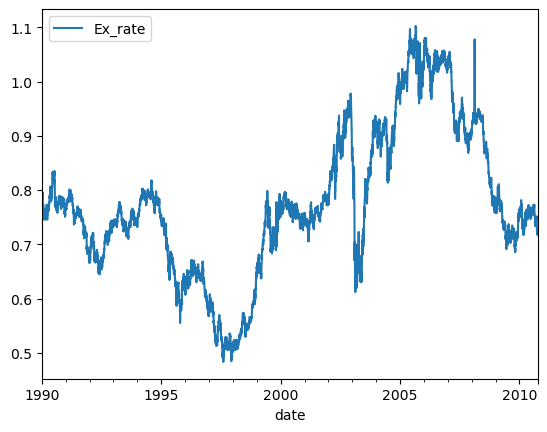

In [8]:
# Plotting the time series
df.plot()

#### Components of Time Series

1. Trend: The long-term movement of the series over time. A trend shows whether the data is increasing, decreasing, or staying relatively constant over a long period. Trends can be linear (straight line) or nonlinear (curved).
2. Seasonality: The repetitive and periodic patterns in the data that occur at regular intervals within a year or across multiple years. Seasonality is often driven by factors such as weather, holidays, or cultural events. It usually follows a fixed and known period.
3. Residual: Also known as noise or error, this component represents the random, unpredictable fluctuations in the data that cannot be attributed to the above three components (trend, seasonality, and cycle). It reflects the noise or variability in the data that cannot be explained by the model.

#### Decomposition

Decomposition refers to the process of breaking down a time series into its constituent components: trend, seasonality, and residual (or error). The goal of decomposition is to separate these underlying patterns from the raw time series data so that each component can be analyzed and modeled separately.

##### Types of Decomposition
There are generally two main types of decomposition methods used in time series analysis:

1. Additive Decomposition: 
   1. In additive decomposition, the time series 𝑦(𝑡) is decomposed into the sum of its components:
                                            𝑦(𝑡)=Trend(𝑡)+Seasonal(𝑡)+Residual(𝑡)
   2. Here, each component is additive, meaning that the effect of each component is added together to reconstruct the original time series.
2. Multiplicative Decomposition: 
    1. In multiplicative decomposition, the time series 𝑦(𝑡) is decomposed into the product of its components:
                                            𝑦(𝑡)=Trend(𝑡)×Seasonal(𝑡)×Residual(𝑡)
    2. Multiplicative decomposition is used when the amplitude of seasonality or trend varies with the level of the series. It's typically applied when the seasonal fluctuations increase or decrease with the level of the time series.
    
#### Choosing Decompostion

Considering the above graph, we can see that the width of the graph at the beginning is almost the same at the end. Hence, it 

In [9]:
model=seasonal_decompose(df['Ex_rate'],model='additive')
model

<Axes: xlabel='date'>

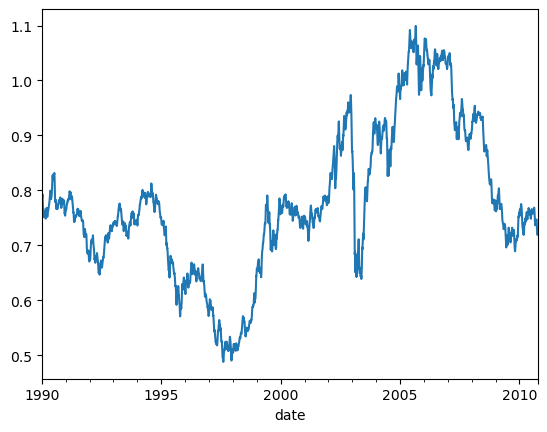

In [10]:
# Visualizing trend plot

model.trend.plot()

<Axes: xlabel='date'>

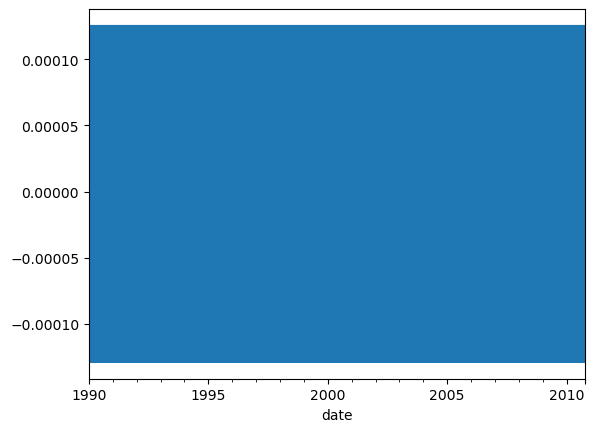

In [11]:
# Visualizing seasonal plot

model.seasonal.plot()

<Axes: xlabel='date'>

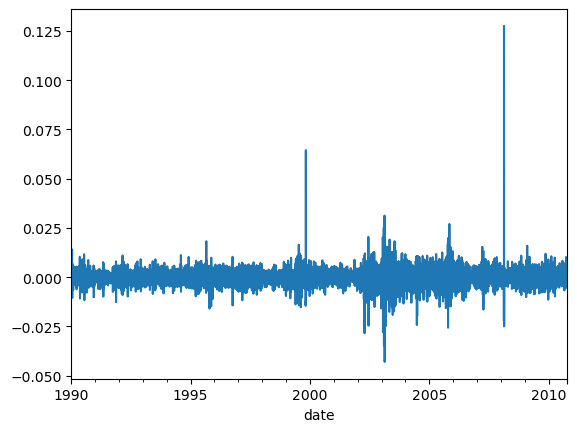

In [12]:
# Visualizing residual plot

model.resid.plot()

#### Analysis from the Visualizations

1. Trends: There is an overall negative trend for the rate of the US Dollar to the Austrailian Dollar, since the exchange rate value at the end is lower than the exchange rate value at the beginning. 
2. Seasonality: There is no seasonality in the exchange rates.
3. Residuals: There is some residual in the dataset.

# Task 2: Model Building - ARIMA

Q1. Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

Q2. Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

Q3. Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

Q4. Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [13]:
# Split dataset into training and testing (80% train, 20% test)

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

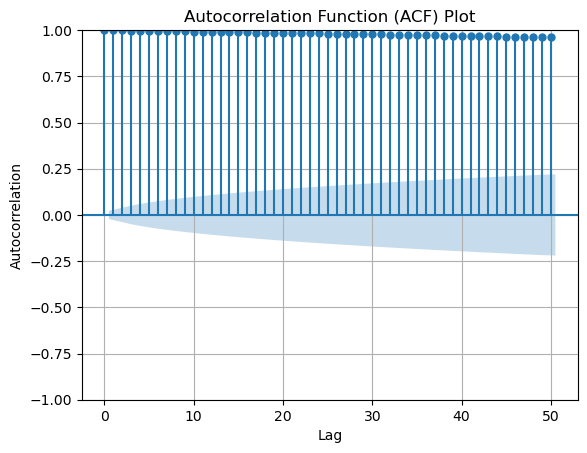

In [14]:
# Visualize Plot ACF
plot_acf(df.Ex_rate, lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

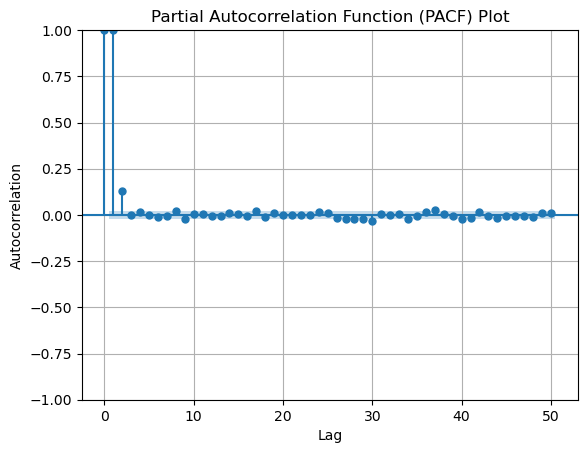

In [15]:
# Visualize Plot PACF
plot_pacf(df.Ex_rate, lags=50)  # Adjust lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.grid(True)
plt.show()

In [16]:
# Getting the ADF Statistic and p-value

result = adfuller(train.Ex_rate.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:', result[4])

ADF Statistic: -0.980855
p-value: 0.760183
Critical Values: {'1%': -3.431429371666765, '5%': -2.8620169839390432, '10%': -2.5670238959668166}


Based on the ACF & PACF Plots and ADF Test results, the the findings indicate that the time series is likely non-stationary.  We will difference the series and visualize the autocorrection plot.

From the ACF & PACF graphs, we can see that the values at lags 1 and 2 are greater than the significance level(0.05), out of which lag 1 is significantly greater, while lag 2 is much lower and might not be as significant. Hence, we will choose q as 1.

##### Transform to stationary: Differencing

<Axes: xlabel='date'>

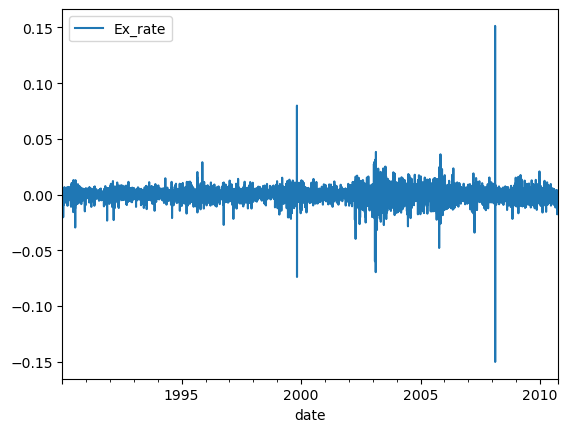

In [17]:
# 1st time differencing 'Ex_rate'

train_diff = df.diff().dropna()
train_diff.plot()

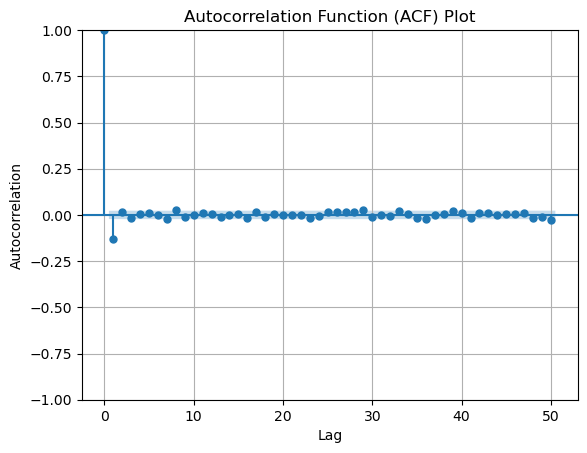

In [18]:
# Visualize ACF plots
plot_acf(train_diff.Ex_rate, lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

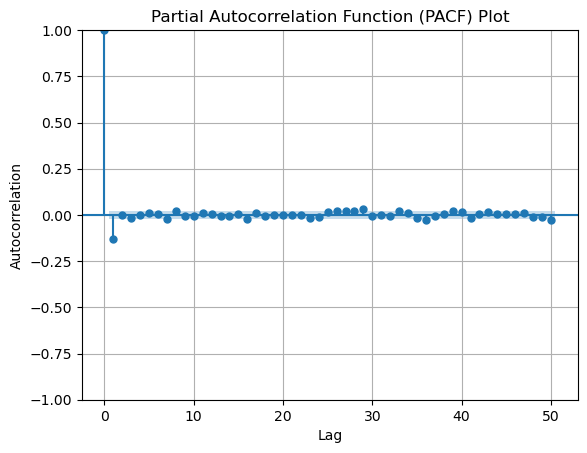

In [19]:
# Visualize Plot PACF
plot_pacf(train_diff.Ex_rate, lags=50)  # Adjust lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.grid(True)
plt.show()

In [20]:
# Getting the ADF Statistic and p-value of 1st differenced data set

result = adfuller(train_diff.Ex_rate.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:', result[4])

ADF Statistic: -99.393431
p-value: 0.000000
Critical Values: {'1%': -3.4312123140180137, '5%': -2.861921078147796, '10%': -2.5669728434336108}


From the above graphs as well as ADF statistics, we can see that the time series reaches stationarity with one order of differencing. Hence, we can set d=1.

Thus, we have calculated the parameters for the ARIMA Model as:
1. p = 0
2. d = 1
3. q = 1

#### Fitting the ARIMA Model

In [21]:
# Instantiate the ARIMA model
model = ARIMA(train['Ex_rate'], order=(0, 1, 1)) # rounding off p value to nearest integer

# Fit the ARIMA model
fitted_model = model.fit()

In [22]:
# Print model summary
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(0, 1, 1)   Log Likelihood               22714.470
Date:                Tue, 09 Jul 2024   AIC                         -45424.940
Time:                        19:47:31   BIC                         -45411.518
Sample:                    01-01-1990   HQIC                        -45420.282
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0574      0.005    -11.333      0.000      -0.067      -0.047
sigma2      3.286e-05   1.84e-07    178.932      0.000    3.25e-05    3.32e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            106050.05
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Interpretation of the Model Summary

1. The SARIMAX model (ARIMA(0, 1, 1)) appears to provide a reasonably good fit to the data based on the AIC and BIC values.
2. The significant MA(1) coefficient suggests that the first-order moving average term is important in explaining the variation in the series.
3. However, the residuals exhibit non-normality and heteroskedasticity, indicating potential areas for improvement or further model refinement.

### Residuals Analysis

In [23]:
# Get residuals

residuals = fitted_model.resid
print("Residuals Mean: ")
residuals.mean()

Residuals Mean: 


0.00017101110209141453

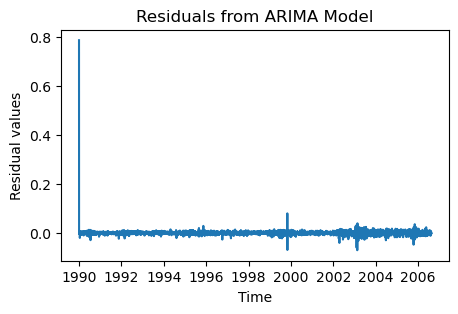

In [24]:
# Plot Residuals

plt.figure(figsize=(5, 3))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residual values')
plt.show()

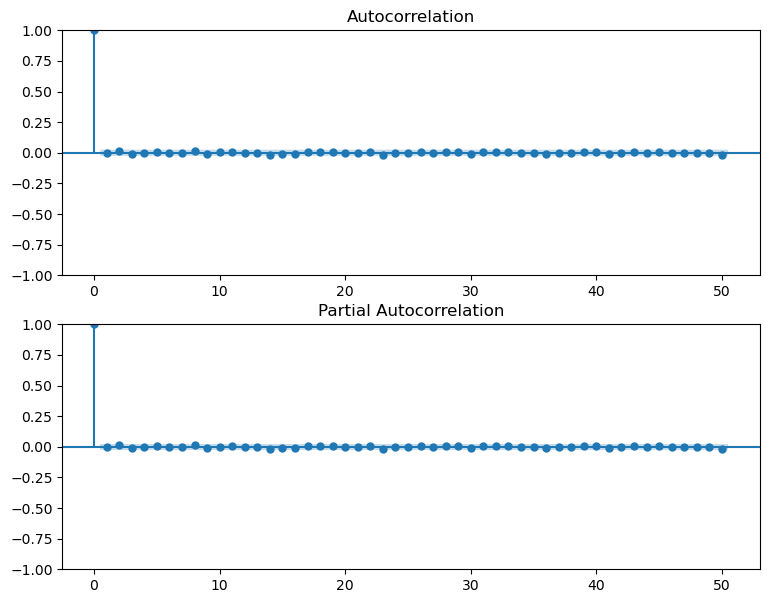

In [25]:
# Visualize ACF and PACF Plots for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7))
plot_acf(residuals, lags=50, ax=ax1)
plot_pacf(residuals, lags=50, ax=ax2)
plt.show()

#### Interpretation of ACF Plot

1. Residual Independence: As all autocorrelation coefficients (values on the plot) at different lags are below the significance level (0.05), it suggests that there is no significant autocorrelation in the residuals.
2. Good Model Fit: This indicates that the model has adequately captured the autocorrelation structure present in the data. Residuals are ideally independent and normally distributed around zero.

#### Interpretation of PACF Plot

1. Residual Independence: This finding indicates that once the the correlations at shorter lags (up to the lag specified by the model) are accounted for, there is no residual correlation left at the longer lags. In other words, any residual correlation present is adequately explained by the model's structure.
2. Model Validity: This implies that the model has effectively captured and accounted for the autocorrelation patterns up to the lag specified by the model (e.g., through the autoregressive component).

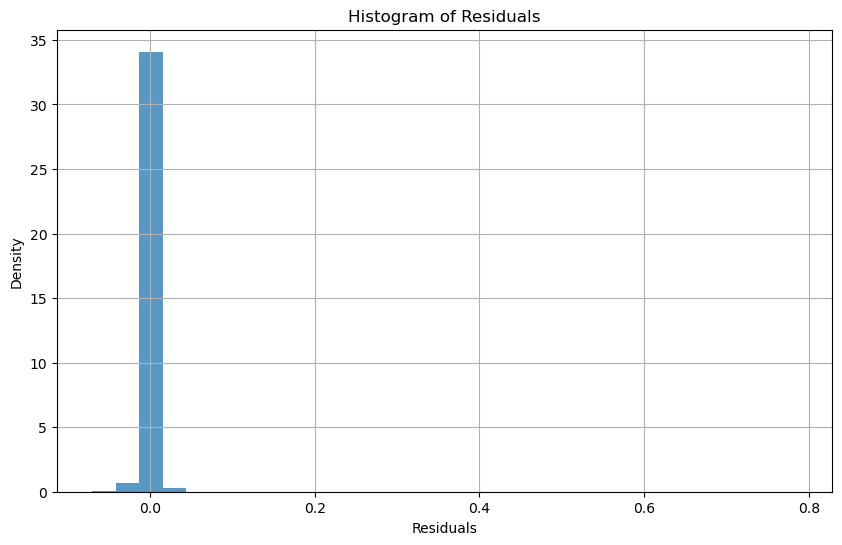

In [26]:
# Visualizng Histogram of residuals

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.75)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

#### Interpreting the Histogram of Residuals:

1. Centered around Zero: The peak at 0.0 indicates that the residuals have a mean very close to zero, which is generally expected and desirable in well-fitted models like ARIMA.
2. Low values on either side of Zero: 
    1. Left of 0.0: The low value to the left of 0.0 suggests that there are a few residuals that are slightly negative but very close to zero.
    2. Right of 0.0: Similarly, the low value to the right of 0.0 indicates that there are a few residuals that are slightly positive but very close to zero.
3. High Value at 0.0: The high value of more than 30 at 0.0 indicates that a significant number of residuals are exactly zero. This could happen if the model perfectly predicts certain observations or if there are patterns in the data that the model captures well.
4. Distribution Shape: The shape of the histogram suggests that the residuals are approximately symmetric around zero, resembling a bell-shaped curve centered at zero. This is indicative of residuals behaving like white noise, which is a desirable characteristic in many modeling contexts.
5. Model Assessment: Such a histogram is generally a positive indication that the ARIMA model is performing well. The residuals are mostly centered around zero with no pronounced skewness or outliers, which suggests that the model adequately captures the underlying patterns in the data.

### Out-of-Sample Forecasting

Performing out-of-sample forecasting involves using the fitted ARIMA model to predict values beyond the last observed data point.

In [27]:
# Forecast out-of-sample
forecast = fitted_model.forecast(steps=len(test))

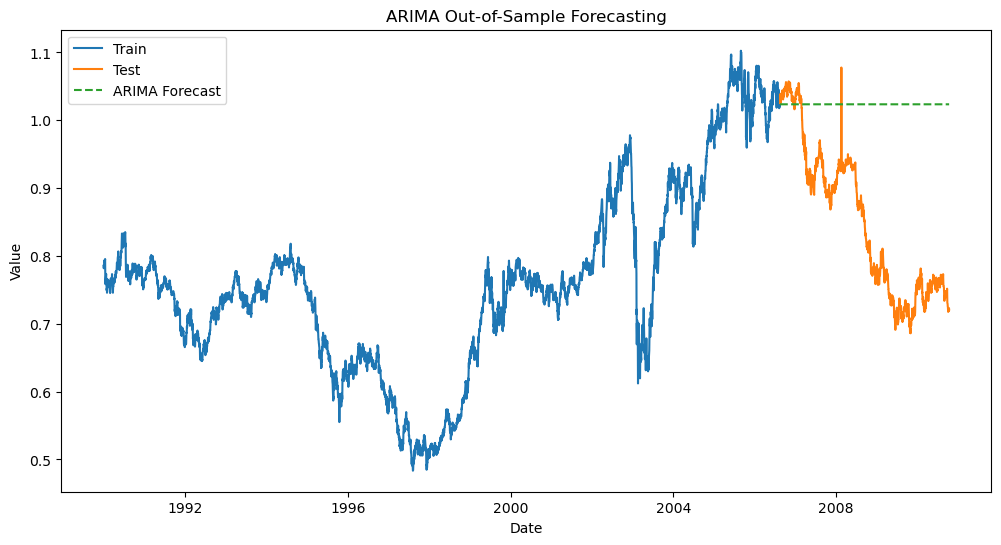

In [28]:
# Plotting the results

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Out-of-Sample Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [29]:
# Calculate standard errors (stderr)
stderr = np.sqrt(fitted_model.forecast(steps=len(test))[1])  # Standard error of the forecast

# Calculate confidence intervals
alpha = 0.05  # 95% confidence interval
z_value = 1.96  # Z-value for 95% confidence interval

lower_ci = forecast - z_value * stderr
upper_ci = forecast + z_value * stderr

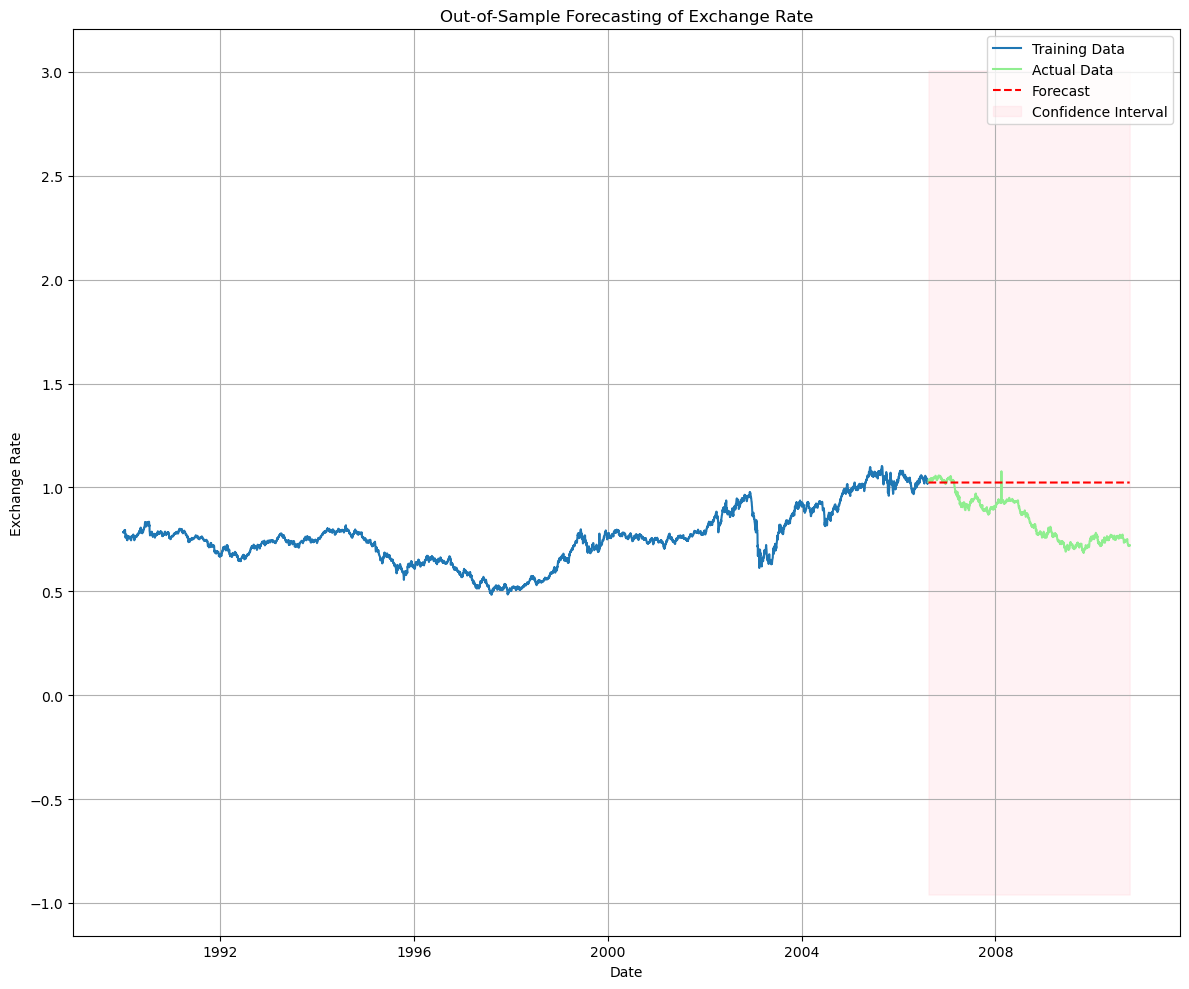

In [30]:
# Visualize the Forecast

# Create DataFrame with forecast and confidence intervals
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual': test['Ex_rate'].values,
    'Forecast': forecast,
    'Lower_CI': lower_ci if 'lower_ci' in locals() else np.nan,
    'Upper_CI': upper_ci if 'upper_ci' in locals() else np.nan
})

# Plotting forecast and confidence intervals
plt.figure(figsize=(12, 10))
plt.plot(train.index, train['Ex_rate'], label='Training Data')
plt.plot(test.index, test['Ex_rate'], label='Actual Data', color='lightgreen')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', linestyle='--', color='red')
if 'lower_ci' in locals() and 'upper_ci' in locals():
    plt.fill_between(forecast_df['Date'], forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.2, 
                     label='Confidence Interval')
plt.title('Out-of-Sample Forecasting of Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Evaluate forecast performance
mse = mean_squared_error(test['Ex_rate'], forecast)
mae = mean_absolute_error(test['Ex_rate'], forecast)
mape = mean_absolute_percentage_error(test['Ex_rate'], forecast)
rmse = np.sqrt(mean_squared_error(test['Ex_rate'], forecast))
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MSE): {mape}")
print(f"Root Mean Squared Error (RMSE): {mse}")

Mean Squared Error (MSE): 0.04217121438373675
Mean Absolute Error (MAE): 0.17763805764478907
Mean Absolute Percentage Error (MSE): 0.227888489505025
Root Mean Squared Error (RMSE): 0.04217121438373675


# Task 3: Model Building - Exponential Smoothing

Q1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

Q2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

Q3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

Based on the time series characteristics, we will go for Simple Exponential Smoothing (SES). It is appropriate when the time series data does not exhibit trend or seasonality. It is used when the data shows no significant trend or seasonality, and the fluctuations are random and do not follow any specific pattern over time.

#### Simple Exponential Smoothing (SES)

In [32]:
# Fit Simple Exponential Smoothing model
model = SimpleExpSmoothing(train)
ses_fit = model.fit()

In [33]:
# Forecast future values for the test set
forecast = ses_fit.forecast(steps=len(test))

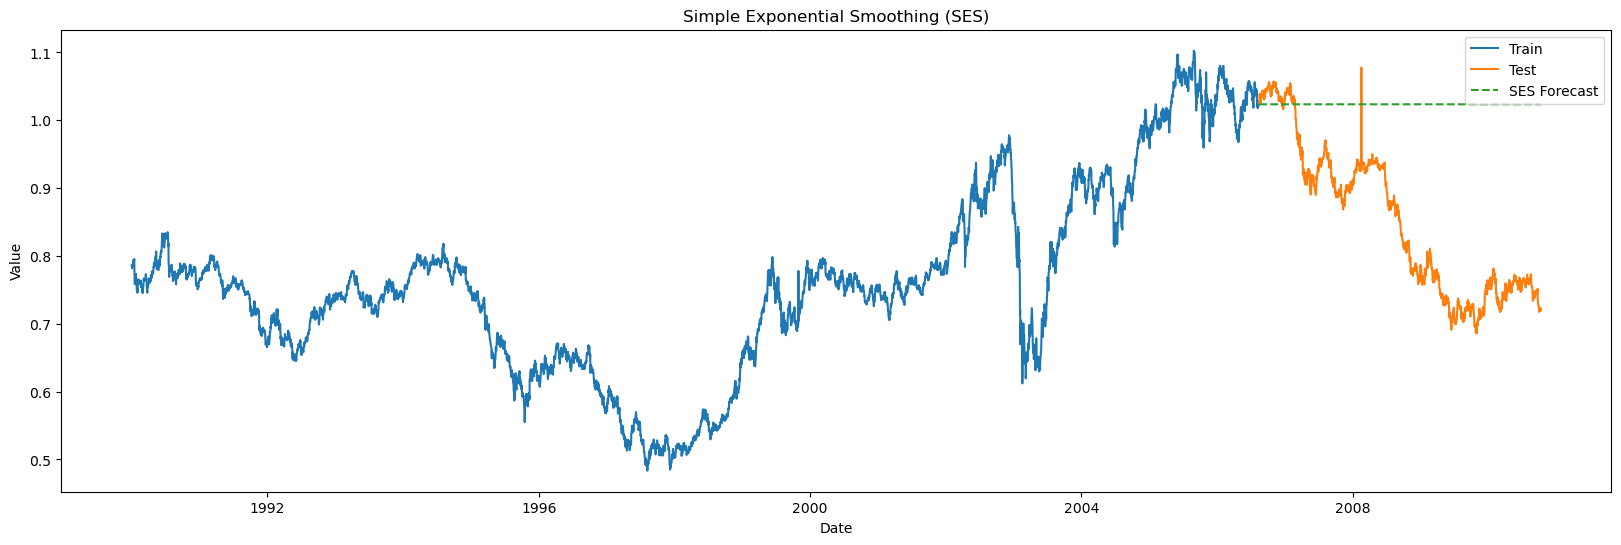

In [34]:
# Plotting the results
plt.figure(figsize=(20, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='SES Forecast', linestyle='--')
plt.title('Simple Exponential Smoothing (SES)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [35]:
# Evaluate forecast performance
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.04217124164715606


#### Parameter Optimization using GridSearchCV

In [36]:
# Parameter grid for alpha (smoothing level)
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [37]:
best_score = float('inf')
best_alpha = None
forecast = None
# Grid search with verbosity
for alpha in alphas:
    print(f"Trying alpha={alpha}")
    model = SimpleExpSmoothing(train)
    ses_fit = model.fit(smoothing_level=alpha)
    forecast = ses_fit.forecast(len(test))
    mse = mean_squared_error(test, forecast)
    
   # print(f"MSE for alpha={test}: {mse}")
    
    if mse < best_score:
        best_score = mse
        best_alpha = alpha
        best_model = ses_fit

# Fit final model on best alpha
final_model = SimpleExpSmoothing(train)
final_fit = final_model.fit(smoothing_level=best_alpha)

# Print best alpha and best MSE score
print("Best alpha:", best_alpha)
print("Best MSE score:", best_score)

Trying alpha=0.1
Trying alpha=0.2
Trying alpha=0.3
Trying alpha=0.4
Trying alpha=0.5
Trying alpha=0.6
Trying alpha=0.7
Trying alpha=0.8
Trying alpha=0.9
Best alpha: 0.4
Best MSE score: 0.04213183157926758


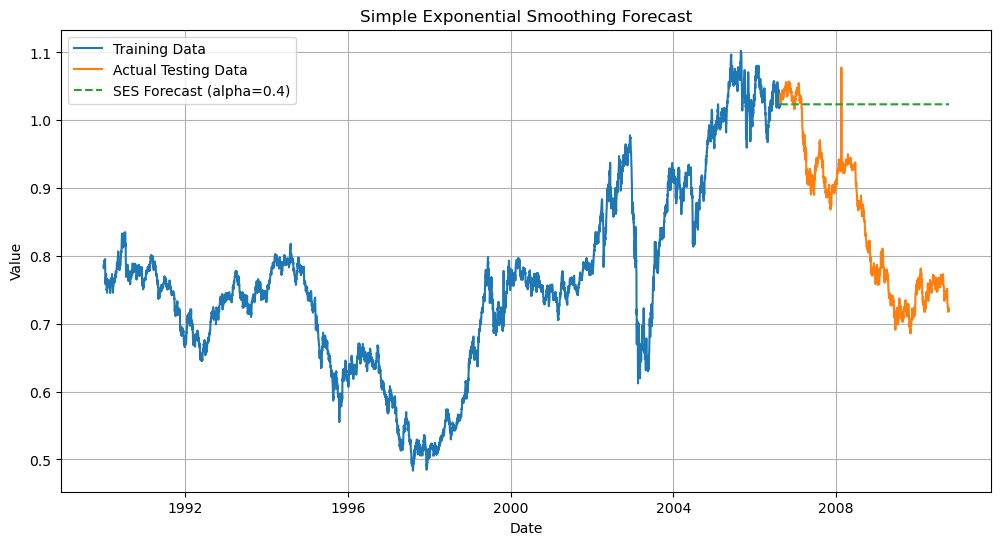

In [38]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Testing Data')
plt.plot(forecast.index, forecast, label=f'SES Forecast (alpha={best_alpha})', linestyle='--')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Evaluate forecast performance
mse = mean_squared_error(test['Ex_rate'], forecast)
mae = mean_absolute_error(test['Ex_rate'], forecast)
mape = mean_absolute_percentage_error(test['Ex_rate'], forecast)
rmse = np.sqrt(mean_squared_error(test['Ex_rate'], forecast))
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MSE): {mape}")
print(f"Root Mean Squared Error (RMSE): {mse}")

Mean Squared Error (MSE): 0.04216776997534838
Mean Absolute Error (MAE): 0.17763058002242835
Mean Absolute Percentage Error (MSE): 0.22787897470369242
Root Mean Squared Error (RMSE): 0.04216776997534838


We can see that the Mean Squared Error (MSE) remains the same before and after parameter tuning.  

# Task 4: Evaluation and Comparison

Q1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

Q2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

Q3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

#### Performance Comparison and Interpretation

1. Mean Squared Error (MSE): Both models have very similar MSE values (0.042171 for Out of Sample and 0.042168 for SES), indicating that they perform almost equally well in terms of predicting the squared differences between forecasted and actual values. Lower MSE values indicate better accuracy.
2. Mean Absolute Error (MAE): The MAE values are also very close (0.177638 for Out of Sample and 0.177631 for SES), suggesting both models are similar in their ability to predict the absolute errors. MAE is easy to interpret since it represents the average magnitude of the errors.
3. Mean Absolute Percentage Error (MAPE): Again, both models show nearly identical MAPE values (0.227888 for Out of Sample and 0.227879 for SES), indicating that they have similar performance in terms of percentage accuracy. MAPE is useful for understanding the relative size of the errors compared to the actual values.
4. Root Mean Squared Error (RMSE): RMSE values are exactly the same for both models (0.042171), indicating identical performance in terms of predicting the root of the average of squared errors. RMSE penalizes larger errors more significantly than MAE.

#### Advantages and Limitations

1. Out of Sample Forecasting:
    1. Advantages:
        1. Can handle complex patterns and dependencies in the data.
        2. Allows for flexibility in model selection and parameter tuning.
    2. Limitations:
        1. May require more computational resources and time to train and evaluate.
        2. Potential overfitting if not properly validated and tested on unseen data.
2. Simple Exponential Smoothing (SES):
    1. Advantages:
        1. Simple and computationally efficient.
        2. Easy to interpret and implement.
    2. Limitations:
        1. Assumes a constant level of the time series (not suitable for highly volatile data).
        2. Limited ability to capture trend and seasonality in the data.

#### Conclusion

Based on the error metrics, both Out of Sample Forecasting and Simple Exponential Smoothing (SES) models perform similarly in terms of accuracy. They achieve almost identical results across MSE, MAE, MAPE, and RMSE, indicating comparable predictive performance on the given dataset.

#### Decision

Given the very close performance metrics, the choice between these models may depend on practical considerations such as model complexity, computational resources, and interpretability. Out of Sample Forecasting may offer more flexibility for complex data patterns but requires careful validation and tuning. SES, on the other hand, is straightforward and efficient but may be limited in capturing certain data characteristics.

#### Recommendation

If computational efficiency and simplicity are priorities and the data exhibits relatively stable patterns, SES could be preferred. For more complex data with varying patterns, Out of Sample Forecasting might be more suitable despite potentially higher computational demands.